In [1]:
import pandas as pd
import numpy as np
import joblib
import typing
import matplotlib.pyplot as plt
import alphagens
from alphagens.factor.preprocessing import get_clean_factor_and_forward_returns, get_clean_factor_and_current_returns
from alphagens.backtest import QuickBackTestor, QuickFactorTestor
from alphagens.utils.metrics import FactorMetrics, StrategyMetrics
from alphagens.data_source.tushare import pro, Stock, Index
from alphagens.utils.calendars import DEFAULT_CALENDAR
from alphagens.utils.format_output import df_to_html
from alphagens.edbt import SimulationEngine, SimulatedBroker, Account, BaseStrategy

In [2]:
alphagens.__version__

'0.4.1'

In [3]:
# 设置环境变量
class Context:
    DATA_PATH = "./data"
    START_DATE = "20100101"
    END_DATE = "20180101"
    BENCHMARK = "000300.SH"
    
    trade_dates = DEFAULT_CALENDAR.sessions_in_range(START_DATE, END_DATE)
    REBALANCE_DATES = DEFAULT_CALENDAR.Weekly(trade_dates)

In [4]:
class DataPortal:
    def __init__(self, load_cov=False):
        start_date = Context.START_DATE
        end_date = Context.END_DATE
        self._all_basic_data: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/tushare.ex_basic")
        self.prices: pd.DataFrame = self._all_basic_data["close"].unstack().fillna(method='ffill')
        self.universe: list[str] = Index.components(ts_code=Context.BENCHMARK, end_date="20180101").index
        self.universe = sorted([x[:-3] for x in self.universe])
    
        self.factors: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/uqer.factor").loc[Context.trade_dates]
        self.industry_map: pd.Series = joblib.load(f"{Context.DATA_PATH}/uqer.industry_map")
        self.benchmark: pd.Series = Index.history(["000300.SH"], start_date, end_date)[0]["close"]
        if load_cov:
            self.covs = joblib.load(f"{Context.DATA_PATH}/tushare.covariance_matrix")

    def history(self, date, symbols: list, field: str, lookback: int = None):
        if lookback is not None:
            slice_dates = DEFAULT_CALENDAR.history(date, lookback)
            return self._all_basic_data.loc[(slice_dates, symbols), field]

    def query_covariance(self, date, symbols, lookback):
        """请注意协方差矩阵的数量级!!!
        """
        if lookback < 2 * len(symbols):
            raise ValueError("lookback must be twice as long as length of symbols")
        slice_data = self.history(date, symbols, "pct_chg", lookback) / 100
        slice_data = slice_data.unstack().fillna(0)
        mean = slice_data.mean(axis=0)
        cov = slice_data.cov()
        return mean, cov
    
    @property
    def factor_names(self):
        return self.factors.columns.to_list()
    
    def factor_get(self, factor_name, dates=None):
        assert factor_name in self.factor_names
        if dates is not None:
            return self.factors.loc[(dates, slice(None)), factor_name]
        else:
            return self.factors[factor_name]
        
    def get_trading_constraints(self, type: typing.Literal["limit_up", "limit_down"]):
        if type == "limit_up":
            return (self._all_basic_data["pct_chg"] >= 10).unstack().fillna(False)
data_portal = DataPortal(True)

In [5]:
from alphagens.pyfolio.optimizer import MinVarPortfolio, BaseOptimizer

In [13]:
# 设计一个优化器
# objective_function
# constraints
# bounds
# 改改就行, 和scipy.optimize.minimize的接口相同的
class MinVarPortfolio(BaseOptimizer):

    def __init__(self, mu, cov):
        super().__init__(mu, cov)
    
    def objective_function(self, weights):
        mu = self.mu
        cov = self.cov
        portfolio_mean = weights.T @ mu
        portfolio_variance = weights.T @ cov @ weights
        max_obj = - portfolio_variance
        return - max_obj

    def constraints(self):
        return ({'type': 'eq', 
                 'fun': lambda weights: np.sum(weights) - 1})
    
    def bounds(self):
        return tuple((0, 1) for _ in range(self.n_assets))

In [14]:
stocks = data_portal.universe[:10] # 选前10只股票进行组合优化

In [15]:
target_positions = pd.DataFrame(np.nan, index=Context.REBALANCE_DATES, columns=stocks)
for date in Context.REBALANCE_DATES:
    # 提取当天的因子暴露, 协方差矩阵
    mu = np.repeat(0, len(stocks)) # 为了简便, 这里使用0作为均值
    cov = data_portal.covs.loc[date].loc[stocks, stocks] # 注意协方差矩阵的数量级, 这里是真是的100^2倍

    # 定义优化器
    optimizer = MinVarPortfolio(mu, cov)
    result = optimizer.run()
    # 进行结果检查, 如果优化失败, 则使用等权重策略
    if result == "FAILED":
        target_position = np.repeat(1/len(stocks), len(stocks))
    else:
        result = optimizer.get_optimal_weights()
    target_positions.loc[date] = target_position

In [17]:
target_positions

,000001,000002,000008,000060,000063,000069,000100,000157,000166,000333
2010-01-08,0.150800,0.042801,0.046516,1.262589e-01,1.578833e-01,1.378676e-01,0.183356,0.033721,0.044983,0.075813
2010-01-15,0.126977,0.177177,0.098668,6.207692e-02,8.842960e-02,1.597400e-01,0.018894,0.117259,0.105178,0.045602
2010-01-22,0.141282,0.124870,0.191194,1.308630e-01,3.830009e-02,1.749201e-02,0.005189,0.239377,0.034214,0.077220
2010-01-29,0.135499,0.019694,0.044498,1.134233e-01,5.063913e-02,2.317646e-02,0.159963,0.054132,0.205426,0.193550
2010-02-05,0.011625,0.059329,0.075654,2.363482e-01,1.049533e-02,2.188546e-01,0.078382,0.026069,0.104532,0.178710
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,0.120069,0.031824,0.143564,1.389134e-17,6.437450e-18,1.454583e-02,0.130143,0.161498,0.340053,0.058303
2017-12-08,0.113006,0.018398,0.139709,1.519262e-17,1.854487e-17,2.433946e-02,0.112623,0.181613,0.344086,0.066225
2017-12-15,0.081693,0.021305,0.115907,3.197170e-17,1.220122e-17,2.164533e-02,0.091433,0.196198,0.397729,0.074090
2017-12-22,0.061077,0.026810,0.146685,0.000000e+00,3.283464e-18,1.578313e-02,0.063713,0.190881,0.411392,0.083660


In [22]:
# 根据target_positions看看效果
bt = QuickBackTestor(Context.START_DATE, Context.END_DATE, data_portal.prices)
strategy_returns = bt.run_backtest(target_positions.reindex(data_portal.universe, axis=1).fillna(0))

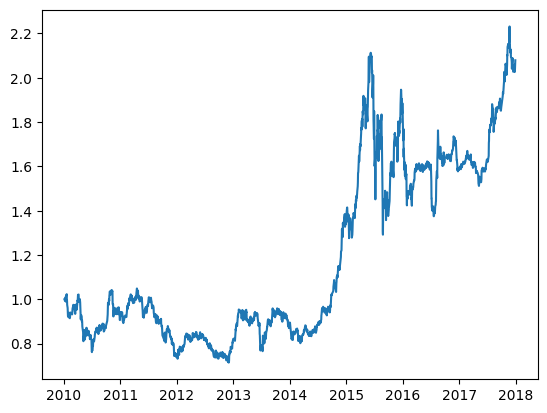

In [24]:
plt.plot((1 + strategy_returns).cumprod())

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Monthly Returns Heatmap'}, xlabel='Month', ylabel='Year'>)

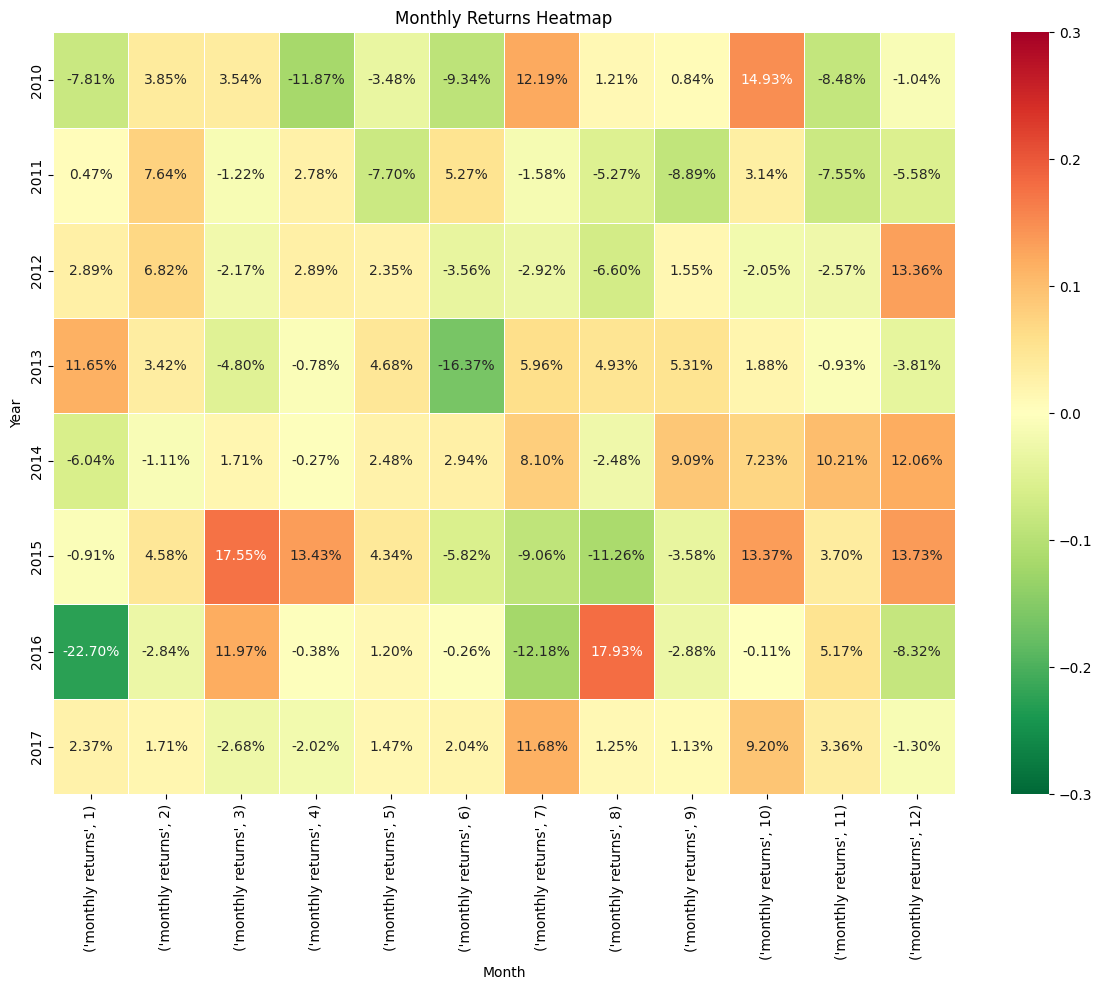

In [23]:
StrategyMetrics.plot_heatmap_of_monthly_returns(strategy_returns)